# Week 8 - Assignment 9.1

In [1]:
#9.1 As sample size increases, the power of a hypothesis test increases, which means it is
#more likely to be positive if the effect is real. Conversely, as sample size decreases, the
#test is less likely to be positive even if the effect is real.
#To investigate this behavior, run the tests in this chapter with different subsets of the
#NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.
#What happens to the p-values of these tests as the sample size decreases? What is the
#smallest sample size that yields a positive test?

In [7]:
import thinkplot
import thinkstats2
import numpy as np
import random
import nsfg 
import hypothesis as hp

In [3]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [5]:
class DiffMeansResample(hp.DiffMeansPermute):
    """Tests a difference in means using resampling."""
    
    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2

In [6]:
def RunResampleTest(firsts, others):
    """Tests differences in means by resampling.

    firsts: DataFrame
    others: DataFrame
    """
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample preglength')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hp.DiffMeansPermute(data)
    p_value = ht.PValue(iters=10000)
    print('\ndiff means resample birthweight')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

In [7]:
#import first

#live, firsts, others = first.MakeFrames()
df_nsfg = nsfg.ReadFemPreg()

not_live = df_nsfg[df_nsfg.outcome != 1]
live = df_nsfg[df_nsfg.outcome == 1]
live_first_born = live[live.birthord ==1]
live_other_born = live[live.birthord!=1]
live_subs = live.dropna(subset=['agepreg', 'totalwgt_lb'])

data = live_first_born.prglngth.values, live_other_born.prglngth.values
RunResampleTest(live_first_born, live_other_born)


diff means resample preglength
p-value = 0.1608
actual = 0.07803726677754952
ts max = 0.21706913264567618

diff means resample birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.11767152317556118


In [8]:
n = len(live) 
cnt=0
print('n      ', 'p1      ', 'p2    ', 'p3     ', 'p4')
iters = 1000
for _ in range(10):
    sample = thinkstats2.SampleRows(live, n) 
    first_born = sample[sample.birthord == 1]
    other_born = sample[sample.birthord != 1]
    
    # compare pregnancy lengths
    preg_lengths_data = first_born.prglngth.values, other_born.prglngth.values
    ht = hp.DiffMeansPermute(preg_lengths_data)
    p1 = ht.PValue(iters=1000)
    
    # compare birthweights
    birthweights_data = (first_born.totalwgt_lb.dropna().values,
            other_born.totalwgt_lb.dropna().values) 
    ht = hp.DiffMeansPermute(birthweights_data)
    p2 = ht.PValue(iters=iters)
    
    # test correlation of mother's age and child's birth weight
    live_corr = sample.dropna(subset=['agepreg', 'totalwgt_lb'])
    preg_lengths_data = live_corr.agepreg.values, live_corr.totalwgt_lb.values
    ht = hp.CorrelationPermute(preg_lengths_data)
    p3 = ht.PValue(iters=iters)
    
    # compare pregnancy lengths (chi-squared)
    chi_preg_lengths_data = first_born.prglngth.values, other_born.prglngth.values
    ht = hp.PregLengthTest(chi_preg_lengths_data)
    np.seterr(invalid='ignore')
    p4 = ht.PValue(iters=iters) 
    
    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))
    n //= 2       

n       p1       p2     p3      p4
9148	0.17	0.00	0.00	0.00
4574	0.48	0.00	0.00	0.00
2287	0.93	0.10	0.00	0.00
1143	0.46	0.00	0.00	0.03
571	0.23	0.56	0.10	0.58
285	0.40	0.58	0.14	0.39
142	0.97	0.67	0.31	0.66
71	0.43	0.10	0.02	0.00
35	0.19	0.46	0.01	0.00
17	0.66	0.34	0.63	0.00


My results:

*---------------------------------------------*

p1: difference in mean pregnancy length

p2: difference in mean birth weight

p3: correlation of mother's age and birth weight

p4: chi-square test of pregnancy length

*---------------------------------------------*

Diff means resample preglength

p-value = 0.1608

actual = 0.07803726677754952

ts max = 0.21706913264567618

*---------------------------------------------*

Diff means resample birthweight

p-value = 0.0

actual = 0.12476118453549034

ts max = 0.11767152317556118

*---------------------------------------------* 
    
Conclusion: 
Tests that are positive with large sample sizes become negative as data reduces.   
Test pattern is not consistent and is erratic. 
We can see positve tests for small data sample as well. 

# Week 8 - Assignment 10.1

In [4]:
#10.1 Using the data from the BRFSS, compute the linear least squares fit for log(weight)
#versus height. How would you best present the estimated parameters for a model like
#this where one of the variables is log-transformed? If you were trying to guess someone’s
#weight, how much would it help to know their height?
#Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight
#for each respondent. In the BRFSS data, the variable name for these weights is
#totalwt. Use resampling, with and without weights, to estimate the mean height of
#respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. 
#How much does correct weighting affect the estimates?

In [8]:
import brfss

In [9]:
brfss_df = brfss.ReadBrfss(nrows=None)
brfss_df = brfss_df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = brfss_df.htm3, brfss_df.wtkg2
weights_log = np.log10(weights)  

In [10]:
inter, slope = thinkstats2.LeastSquares(heights, weights_log)
inter, slope

(0.9930804163918192, 0.005281454169417767)

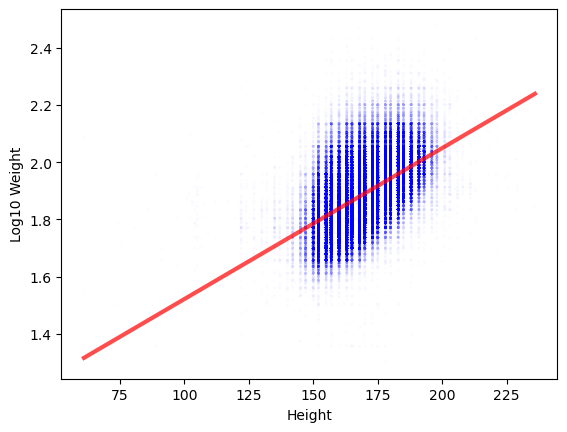

In [11]:
#Make a scatter plot of the data and show the fitted line.
fit_xs, fit_ys = thinkstats2.FitLine(heights, inter, slope) 
thinkplot.Scatter(heights, weights_log, alpha=0.01, s=5) 
thinkplot.Plot(fit_xs, fit_ys, color='red')
thinkplot.Config(xlabel='Height', ylabel='Log10 Weight', legend=False)

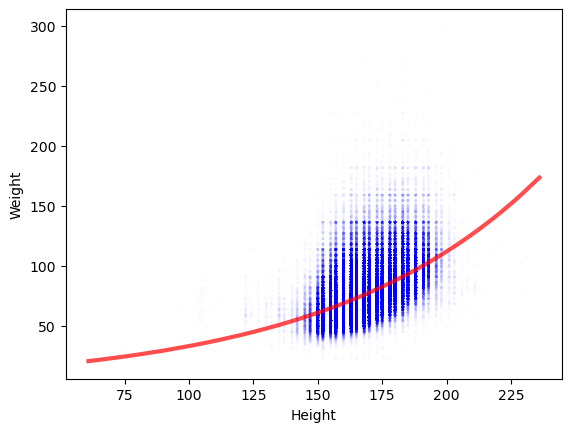

In [12]:
#Same plot but applying the inverse transform to show weights on a linear scale.
f_xs, f_ys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
thinkplot.Plot(f_xs, 10**f_ys, color='red')
thinkplot.Config(xlabel='Height', ylabel='Weight', legend=False)

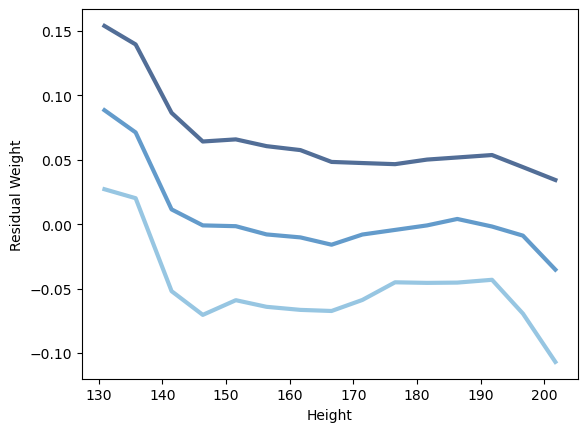

In [13]:
#Plot percentiles of the residuals.
# Solution goes here
residuals=thinkstats2.Residuals(heights,weights_log,inter,slope)
brfss_df['residual']=residuals
bins=np.arange(130,210,5)
ind=np.digitize(brfss_df.htm3,bins)
grps=brfss_df.groupby(ind)

means=[grp.htm3.mean() for i, grp in grps][1:-1]
cdfs=[thinkstats2.Cdf(grp.residual) for i, grp in grps][1:-1]

thinkplot.PrePlot(3)
for percent in [75,50,25]:
    y=[cdf.Percentile(percent) for cdf in cdfs]
    label='%dth' % percent
    thinkplot.Plot(means,y,label=label)
    
thinkplot.Config(xlabel='Height',ylabel='Residual Weight')

In [14]:
#Compute Correlation 
ht_wt_correlation = thinkstats2.Corr(heights,weights_log)
ht_wt_correlation

0.5317282605983424

In [15]:
#Compute coefficient of determination
coefficient=thinkstats2.CoefDetermination(weights_log,residuals)
coefficient

0.28273494311893876

In [20]:
#Confirm that  𝑅2=𝜌2
ht_wt_correlation**2-coefficient,np.isclose(ht_wt_correlation**2, coefficient)
#np.isclose - Returns a boolean array where two arrays are element-wise equal within a tolerance

(0.0, True)

In [21]:
#Compute Std(ys), which is the RMSE of predictions that don't use height.
ys_std=thinkstats2.Std(weights_log)
ys_std

0.10320725030004886

In [22]:
#Compute Std(res), the RMSE of predictions that do use height.
res_std=thinkstats2.Std(residuals)
res_std

0.0874077708041609

In [23]:
#How much does height information reduce RMSE?
1-(res_std/ys_std)

0.1530849765879334

In [24]:
#Use resampling to compute sampling distributions for inter and slope.
estimate_list=[]

for i in range(100):
    sample=thinkstats2.ResampleRows(brfss_df)
    est=thinkstats2.LeastSquares(sample.htm3,np.log10(sample.wtkg2))
    estimate_list.append(est)
    
inter,slope=zip(*estimate_list)
#inter,slope 

{'xscale': 'linear', 'yscale': 'linear'}

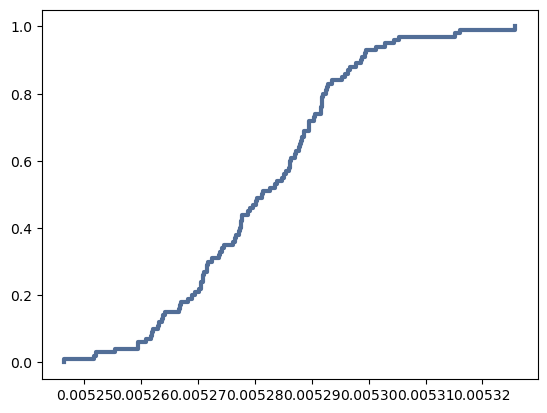

In [25]:
#Plot the sampling distribution of slope.
cdf=thinkstats2.Cdf(slope)
thinkplot.Cdf(cdf)

In [26]:
#Compute the p-value of the slope.
pvalue=cdf[0]
pvalue

0

In [27]:
#Compute the 90% confidence interval of slope.
confidence_interval=cdf.Percentile(5),cdf.Percentile(95)
confidence_interval

(0.005259348105154235, 0.005302822447494455)

In [28]:
#Compute the mean of the sampling distribution.
mean=thinkstats2.Mean(slope)
mean

0.005281327462938837

In [29]:
#Compute the standard deviation of the sampling distribution, which is the standard error.
std_error=thinkstats2.Std(slope)
std_error

1.4508136293916886e-05

In [30]:
#Resample rows without weights, compute mean height, and summarize results.
est_without_weight=[thinkstats2.ResampleRows(brfss_df).htm3.mean() for i in range(100)]
print("Mean Height",thinkstats2.Mean(est_without_weight))
print('Standard error',thinkstats2.Std(est_without_weight))
cdf=thinkstats2.Cdf(est_without_weight)
ci=cdf.Percentile(5),cdf.Percentile(95)
print('Confidence Interval',ci) 

Mean Height 168.95528600517392
Standard error 0.015423644516628907
Confidence Interval (168.92803007336445, 168.97904919258676)


In [31]:
#Resample rows with weights. Note that the weight column in this dataset is called finalwt.
weight=brfss_df['finalwt']
cdf=thinkstats2.Cdf(dict(weight))
indices=cdf.Sample(len(weight))
sample=brfss_df.loc[indices]

est_with_weight=[sample.htm3.mean() for i in range(100)]
print("Mean",thinkstats2.Mean(est_with_weight))
print('Standard error',thinkstats2.Std(est_with_weight))
cdf=thinkstats2.Cdf(est_with_weight)
ci=cdf.Percentile(5),cdf.Percentile(95)
print('Confidence Interval',ci)

Mean 170.50511328038155
Standard error 2.842170943040401e-14
Confidence Interval (170.50511328038158, 170.50511328038158)
